In [2]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from scipy.stats import norm, t
from FES import FES
import random
from collections import deque
from collections import defaultdict

In [67]:
assignmentGraph = nx.read_gml('networkAssignment_1.gml')

# Define the arrival rates per hour (vehicles per hour)
arrival_rates = {
    0: 314.2, 1: 162.4, 2: 138.6, 3: 148.8, 4: 273.2, 5: 1118.8, 6: 2773.8, 7: 4036.2,
    8: 4237.4, 9: 3277.0, 10: 2843.0, 11: 2876.4, 12: 3143.0, 13: 3277.8, 14: 3546.2, 15: 4335.0,
    16: 4945.4, 17: 4525.8, 18: 2847.8, 19: 1828.0, 20: 1378.4, 21: 1271.2, 22: 1171.2, 23: 767.6
}

# Define vehicle types and their properties
vehicle_types = {
    'car': {'probability': 0.9, 'max_speed': 100},  # 90% cars, max speed 100 km/h
    'truck': {'probability': 0.1, 'max_speed': 80}  # 10% trucks, max speed 80 km/h
}

# Define City A and City B
city_A = '43108886'
city_B = '44996729'

# Function to calculate travel time for a link
def calculate_travel_time(link_length, max_speed):
    mean_travel_time = link_length / max_speed  # in hours
    std_dev = mean_travel_time / 20  # standard deviation
    travel_time = norm.rvs(loc=mean_travel_time, scale=std_dev)  # normally distributed
    return travel_time * 60  # convert to minutes

def calculate_statistics(data):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    confidence_interval = t.interval(0.95, len(data)-1, loc=mean, scale=std_dev/np.sqrt(len(data)))
    return mean, std_dev, confidence_interval

In [123]:


class Vehicles:
    def __init__(self,origin, destination, vehicle_type, path, timestamp, reroutes = False):
        self.origin = origin
        self.destination  = destination
        self.vehicle_type = vehicle_type
        self.v_max = 100 if vehicle_type == 'car' else 80
        self.path = path
        self.curren_position = origin
        self.reroutes = reroutes
        self.start_time = timestamp
        self.travel_time = 0
        self.delayed_time = 0
        self.incident_count = 0
        self.estimated_travel_time = 0
        self.estimated_exit_time =0
        self.link_idx = 0
        self.arr_incident = 0
        u = self.path[self.link_idx]
        w = self.path[self.link_idx + 1]
        self.current_link = (u,w)
        self.travelled_dist = 0
        self.curr_delayed_time = 0
    def update_position(self, current_time,fes, veh_on_link,G):
        
        
        
        
        self.link_entry_time = current_time
        u,w = self.current_link
        distance = G[u][w]['length']/1000 # convert to km
        self.travelled_dist += distance
        travel_time = calculate_travel_time(distance, self.v_max)
        
        self.estimated_exit_time = current_time + travel_time
        self.estimated_travel_time += travel_time


        veh_on_link[(u, w)].append(self)
        self.link_idx +=1
        # Schedule the next move
        fes.add(Event(self.estimated_exit_time, 'move_next_link', self))

        

    def add_delay(self, delay_time):
        self.delayed_time += delay_time
        
        #self.estimated_exit_time += delay_time
        self.incident_count += 1
class Event:
    def __init__(self, timestamp, event_type, vehicle= None, link = None, link_length = None):
        self.timestamp = timestamp
        self.event_type = event_type
        self.vehicle = vehicle
        self.link = link
        self.link_length = link_length
    def __lt__(self, other):
        return self.timestamp < other.timestamp

In [165]:

def simulate_traffic_fes(G, arrival_rates, vehicle_types, city_A, city_B,incident_rates, incident_durations, fract_nav, num_runs=10):
    all_travel_times =[]
    all_truck_travel_times = []
    all_car_travel_times = []
    all_AB_travel_times = []
    all_delay_times = []
    all_incident_counter = []
    all_tot_num_veh = []
    all_route_length = []
    all_del_veh_counter =[]
    inc_count_times = {} # time k incidents active
    delayed_veh = {} # time k vehicles delayed
   

    inc_count_times = defaultdict(int) # inspiration from chatgpt
    delayed_veh = defaultdict(float)
    delayed_veh_counter = defaultdict(int)
    for _ in range(num_runs):
        active_inc_count = 0
        
        veh_delay_count = 0
        
        incident_counter = []
        traveling_time = []
        delay_times = []
        truck_travel_times = []
        car_travel_times = []
        AB_travel_times = []
        fes = FES()
        nodes = list(G.nodes)
        delayed_veh_counter = {} # number of vehicles delayed per hour
        delayed_veh_counter = defaultdict(int)
        for u, w in G.edges:
            G[u][w]['incident_active'] = False
        
        veh_on_link = {}
        veh_on_link = defaultdict(list)
        tot_num_veh = 0
        route_length= []
        for hour in range(24):
            rate = arrival_rates[hour]
            num_vehicles = np.random.poisson(rate)
            tot_num_veh +=num_vehicles
            current_time = hour*60
            inc_rate = incident_rates[hour]
            num_incidents = np.random.poisson(inc_rate)
            start_time = 0
            start_time_que = 0
            
            for _ in range(num_incidents):
                u,w = random.choice(list(G.edges))
                start_incident = np.random.exponential(scale=60 / inc_rate)
                link_length = G[u][w]['length']
                incident_time = current_time+ start_incident
                
                fes.add(Event(incident_time,'start incident', link =(u,w),link_length= link_length ))
                incident_duration = np.random.exponential(incident_durations[hour]) 
                end_incident = incident_time + incident_duration

                fes.add(Event(end_incident, ' end incident', link = (u,w)))
            
                


                
            for _ in range(num_vehicles):
                # Randomly select origin and destination
                origin, destination = np.random.choice(nodes, size=2, replace=False)

                # Randomly select vehicle type
                vehicle_type = np.random.choice(list(vehicle_types.keys()), p=[v['probability'] for v in vehicle_types.values()])
                reroutes = np.random.rand() < fract_nav
                path = nx.shortest_path(G,origin, destination,weight = 'length')
                inter_arrival_time = np.random.exponential(scale=60 / rate)
                arrival_time = current_time + inter_arrival_time
                v = Vehicles(origin, destination, vehicle_type, path,arrival_time, reroutes)
                fes.add(Event(arrival_time,'arrival',v))
                
        while not fes.isEmpty():
                    
                    event = fes.next()
                    
                    
                    time = event.timestamp
                    hour = int(np.floor(time/60))
                    
                    if event.event_type == 'arrival':
                        vehicle = event.vehicle
                        vehicle.link_idx = 0
                        u,w = vehicle.current_link 
                        if G[u][w].get('incident_active', False): 
                            vehicle.arr_incident = time
                            G[u][w]['queue'].append(vehicle)
                            veh_delay_count +=1
                            delayed_veh[veh_delay_count] += time -start_time_que
                            start_time_que = time
                            delayed_veh_counter[hour]+= 1
                        else:
                            
                            vehicle.update_position(time,fes, veh_on_link,G)

                    elif event.event_type == 'move_next_link':
                
                        vehicle = event.vehicle
                        
                             
                        if vehicle.path[vehicle.link_idx] == vehicle.destination:
                
                            fes.add(Event(current_time, 'departure',vehicle))
                            incident_counter.append(vehicle.incident_count)
                            travelled_time = vehicle.estimated_travel_time + vehicle.delayed_time
                            
                            traveling_time.append(travelled_time)
                            incident_counter.append(vehicle.incident_count)
                            delay_times.append(vehicle.delayed_time)
                            route_length.append( vehicle.travelled_dist)
                            if vehicle.vehicle_type == 'truck':
                                    truck_travel_times.append(travelled_time)
                            else:
                                        car_travel_times.append(travelled_time)
                                        if vehicle.origin == city_A and vehicle.destination == city_B:
                                            AB_travel_times.append(travelled_time)
                            continue
                            
                        u,w = vehicle.current_link
                        if G[u][w].get('incident_active', False) and vehicle.reroutes:
                            u = vehicle.current_link[0] 
                            e = vehicle.destination
                            original_length = G[u][w]['length']
                            G[u][w]['length'] = float('inf')
                            path = nx.shortest_path(G, source=u, target=e, weight='length')
                            vehicle.path = path

                            G[u][w]['length'] = original_length
                            vehicle.link_idx = 0
                            w = vehicle.path[vehicle.link_idx +1]
                            
                        
                        if G[u][w].get('incident_active', False) and vehicle in G[u][w]['queue']:
                            continue
                        elif G[u][w]['incident_active']== True:
                            vehicle.arr_incident = time

                            G[u][w]['queue'].append(vehicle)
                            
                            delayed_veh[veh_delay_count] += time -start_time_que
                            veh_delay_count +=1
                            start_time_que = time

                            delayed_veh_counter[hour]+= 1
                        else: 
                            
                            vehicle.update_position(time,fes, veh_on_link,G)
                            if vehicle in veh_on_link[(u, w)]:
                                veh_on_link[(u, w)].remove(vehicle)
                        
                        
                    
                        
                    elif  event.event_type == 'start incident':
                        
                        inc_duration = time - start_time
                        inc_count_times[active_inc_count]+= inc_duration
                        active_inc_count += 1
                        start_time = time
                        

                        u,w= event.link
                        G[u][w] ['incident_active']= True
                        
                        
                        G[u][w]['queue'] = deque()
                        link_length = event.link_length 
                        affected_vehicle = []
                        

                        for veh in veh_on_link[(u,w)]:
                            
                            if veh.link_entry_time<= time <= (veh.link_entry_time + 0.75*link_length/veh.v_max): 
                                veh.arr_incident = time 
                                affected_vehicle.append(veh)
                                
                        G[u][w]['queue'] = deque(affected_vehicle)
                        veh_delay_count +=len(affected_vehicle)
                        delayed_veh[veh_delay_count] += time -start_time_que
                        start_time_que = time

                        delayed_veh_counter[hour]+= len(affected_vehicle)
                        
                        
                        
                    
                    elif event.event_type == ' end incident':
                        # resetting the dictionary that 
                        inc_duration = time - start_time
                        inc_count_times[active_inc_count]+= inc_duration
                        active_inc_count -= 1
                        start_time = time


                        u,w = event.link
                        G[u][w] ['incident_active']= False
                        
                        queue = G[u][w].get('queue', deque())
                        discharge_rate = G[u][w].get('lanes')
                        discharge_time = time
                        
                        while queue:
                            vehicle = queue.popleft()
                            
                            discharge_time += 1/discharge_rate
                            veh_delay_count -=1
                            delayed_veh[veh_delay_count] += discharge_time -start_time_que
                            start_time_que = discharge_time
                            vehicle.curr_delayed_time = discharge_time - vehicle.arr_incident
                            vehicle.delayed_time += vehicle.curr_delayed_time
                            
                            vehicle.incident_count += 1
                            
                            if vehicle in veh_on_link[(u, w)]:
                                veh_on_link[(u, w)].remove(vehicle)


                      
        
        all_tot_num_veh.append(tot_num_veh)
        all_travel_times.append(traveling_time)
        all_truck_travel_times.append(truck_travel_times)
        all_car_travel_times.append(car_travel_times)
        all_AB_travel_times.append(AB_travel_times)    
        all_delay_times.append(delay_times)
        all_incident_counter.append(incident_counter)  
        all_route_length.append(route_length)

        fract_inc_count_time = {k: v / (num_runs * 60 * 24) for k, v in inc_count_times.items()}
        fract_delay_times = {k: v / (num_runs * 60 * 24) for k, v in delayed_veh.items()}
        all_del_veh_counter.append(delayed_veh_counter)
    
    return all_tot_num_veh, all_route_length, all_travel_times, all_truck_travel_times, all_car_travel_times, all_AB_travel_times, all_delay_times, all_incident_counter,fract_inc_count_time ,fract_delay_times, all_del_veh_counter


In [166]:
incident_rates = {0: 0.25806451612903225,
 1: 0.12903225806451613, 2: 0.12903225806451613,
 3: 0.06451612903225806,
 4: 0.03225806451612903,
 5: 0.16129032258064516,
 6: 32.67741935483871,
 7: 153.25806451612902,
 8: 177.2258064516129,
 9: 43.774193548387096,
 10: 7.838709677419355,
 11: 8.387096774193548,
 12: 10.709677419354838,
 13: 10.67741935483871,
 14: 17.516129032258064,
 15: 66.35483870967742,
 16: 177.19354838709677,
 17: 179.16129032258064,
 18: 33.67741935483871,
 19: 2.0,
 20: 0.9354838709677419,
 21: 1.032258064516129,
 22: 1.0,
 23: 0.6774193548387096}
incident_durations = {
    0: 12.8, 1: 12.8, 2: 12.8, 3: 12.8, 4: 12.8, 5: 12.8, 6: 12.8, 7: 12.8,
    8: 12.8, 9: 12.8, 10: 12.8, 11: 12.8, 12: 12.8, 13: 12.8, 14: 12.8, 15: 12.8,
    16: 12.8, 17: 12.8, 18: 12.8, 19: 12.8, 20: 12.8
    , 21: 12.8, 22: 12.8, 23: 12.8
}

tot_num_veh, tot_route_length, all_travel_times, all_truck_travel_times, all_car_travel_times, all_AB_travel_times, all_delay_times, all_incident_counter,time_per_k_inc, time_per_k_delayed_veh , veh_delayed_per_h = simulate_traffic_fes(assignmentGraph,arrival_rates, vehicle_types, city_A=city_A,city_B=city_B,incident_rates = incident_rates,incident_durations= incident_durations, fract_nav = 0.2,num_runs=3)



In [168]:
mean_total_vehicles, std_total_vehicles, ci_total_vehicles = calculate_statistics(tot_num_veh)
mean_route_length, std_route_length, ci_route_length = calculate_statistics([item for sublist in tot_route_length for item in sublist])
mean_travel_time, std_travel_time, ci_travel_time = calculate_statistics([item for sublist in all_travel_times for item in sublist])
mean_truck_travel_time, std_truck_travel_time, ci_truck_travel_time = calculate_statistics([item for sublist in all_truck_travel_times for item in sublist])
mean_car_travel_time, std_car_travel_time, ci_car_travel_time = calculate_statistics([item for sublist in all_car_travel_times for item in sublist])
mean_AB_travel_time, std_AB_travel_time, ci_AB_travel_time = calculate_statistics([item for sublist in all_AB_travel_times for item in sublist])
mean_inc_per_veh,std_inc_per_veh, ciinc_per_veh = calculate_statistics([item for sublist in all_incident_counter for item in sublist])

# Print the results in a table format
print("Performance Measure | Mean | Standard Deviation | 95% Confidence Interval")
print("---------------------------------------------------------------")
print(f"Total number of vehicles | {mean_total_vehicles:.2f} | {std_total_vehicles:.2f} | {ci_total_vehicles}")
print(f"Travel time (arbitrary vehicle) | {mean_travel_time:.2f} | {std_travel_time:.2f} | {ci_travel_time}")
print(f"Travel time (truck) | {mean_truck_travel_time:.2f} | {std_truck_travel_time:.2f} | {ci_truck_travel_time}")
print(f"Travel time (car) | {mean_car_travel_time:.2f} | {std_car_travel_time:.2f} | {ci_car_travel_time}")
print(f"Travel time from A to B (car) | {mean_AB_travel_time:.2f} | {std_AB_travel_time:.2f} | {ci_AB_travel_time}")
print(f"Route length | {mean_route_length:.2f} | {std_route_length:.2f} | {ci_route_length}")
print(f"Incidents per vehicle | {mean_inc_per_veh:.2f} | {std_inc_per_veh:.2f} | {ciinc_per_veh}")

Performance Measure | Mean | Standard Deviation | 95% Confidence Interval
---------------------------------------------------------------
Total number of vehicles | 55318.67 | 276.36 | (54632.15268892776, 56005.18064440557)
Travel time (arbitrary vehicle) | 41.60 | 32.84 | (41.42502877356001, 41.77425640557383)
Travel time (truck) | 49.34 | 36.80 | (48.726266077987376, 49.95166301773604)
Travel time (car) | 40.72 | 32.24 | (40.539827362870355, 40.90165395491822)
Travel time from A to B (car) | 18.54 | 2.58 | (18.316412033252014, 18.77098286355878)
Route length | 52.33 | 34.15 | (52.153422410616045, 52.51657021561013)
Incidents per vehicle | 0.31 | 0.48 | (0.30520961063247165, 0.30878584147111443)


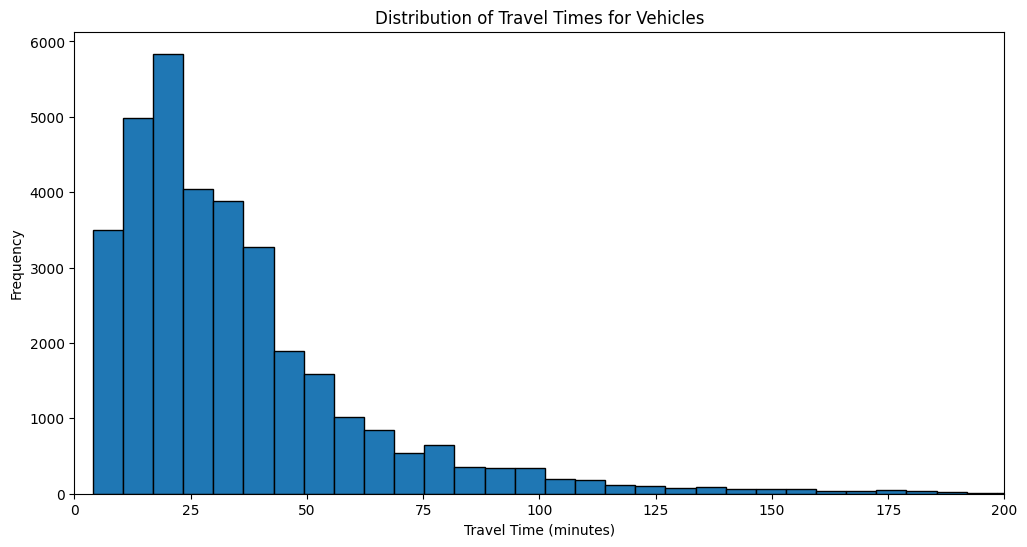

In [115]:

plt.figure(figsize=(12, 6))

# Plotting the travel time distribution
plt.hist([item for sublist in all_travel_times for item in sublist], bins=100, edgecolor='black')
plt.title('Distribution of Travel Times for Vehicles')
plt.xlabel('Travel Time (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, 200)
plt.show()

In [162]:
combined = defaultdict(list)

for hourly_dict in veh_delayed_per_h:  # list of defaultdicts or dicts
    for hour, val in hourly_dict.items():
        combined[hour].append(val)

# Calculate the average for each hour
hour_means = {hour: sum(values) / len(values) for hour, values in combined.items()}
hour_means

{5: 22.0,
 6: 4812.0,
 7: 13305.0,
 8: 13175.0,
 9: 4348.0,
 10: 980.0,
 11: 878.0,
 12: 1651.0,
 13: 2468.0,
 14: 2203.0,
 15: 12877.0,
 16: 14782.0,
 17: 17906.0,
 18: 3173.0,
 21: 39.0,
 22: 77.0}

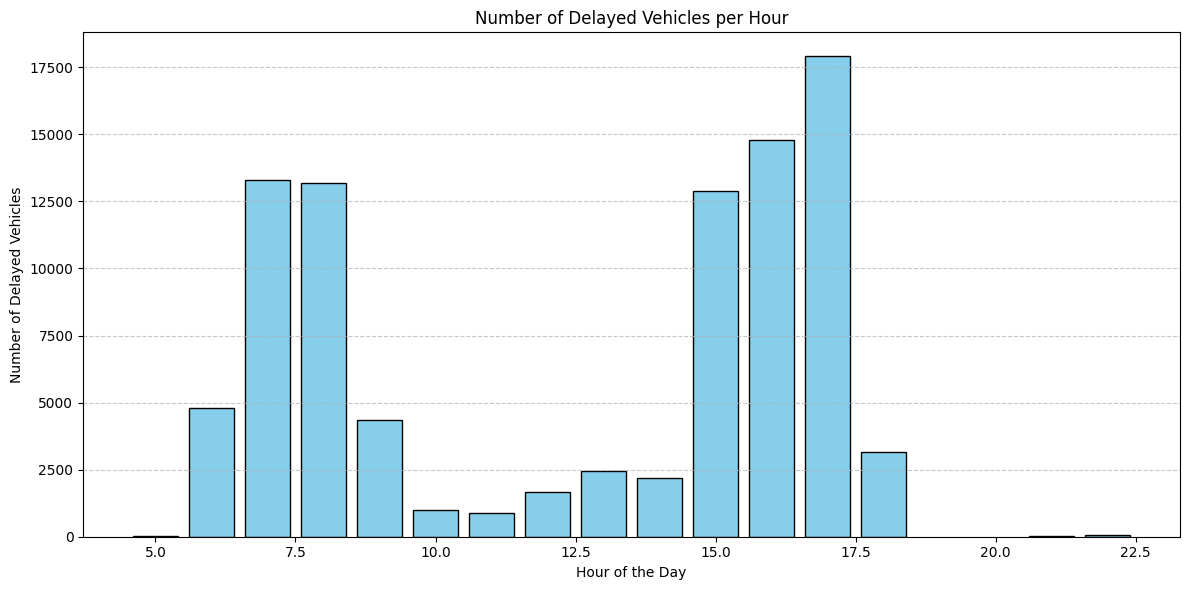

In [173]:
hours = hour_means.keys()
values = [hour_means[h] for h in hours]
plt.figure(figsize=(12, 6))
plt.bar(hours, values, color='skyblue', edgecolor='black')
plt.title('Number of Delayed Vehicles per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delayed Vehicles')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [169]:
top_time_k_incidents = dict(sorted(time_per_k_inc.items(),key=lambda item: item[1],reverse = True)[:7])
top_time_k_incidents

{0: 0.6002285373442369,
 1: 0.11226682944829329,
 2: 0.05221632921111262,
 3: 0.04104817250490782,
 4: 0.034066325825848794,
 5: 0.026769060858993384,
 6: 0.025036809521057232}

In [170]:
top_time_k_veh = dict(sorted(time_per_k_delayed_veh.items(),key=lambda item: item[1],reverse = True)[:7])
top_time_k_veh

{130: 0.08335971238538717,
 71: 0.08333770261939592,
 69889: 0.08032779435450224,
 5: 0.04697686717424953,
 70118: 0.038487280022394176,
 16: 0.02895615474594335,
 70403: 0.016998561036684668}